references:  
https://www.kaggle.com/code/sorkun/house-prices-simple-workflow-lb-0-12426  
https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook  
https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook?scriptVersionId=12846740


## initialize
data <-train.csv  
test <-test.csv

In [1]:
import numpy as np 
import pandas as pd 
#UTILS
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
#MODELS
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

data_b = data.drop(['Id'], axis=1) 
test_b = test.drop(['Id'], axis=1) 
data_b.head()
data['SalePrice'].isnull().sum()

0

In [4]:
test_b.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [5]:
data_b.shape, test_b.shape

((1460, 80), (1459, 79))

In [6]:
concat = pd.concat([data, test]).reset_index(drop=True)
concat = concat.drop(['Id'], axis=1)
#concat.head()
concat.shape

(2919, 80)

## data research

In [7]:
# Analyse missing Values
# data.info()
# data_b.isnull().sum().sort_values(ascending=False).head(20)

missing_data = pd.concat([data_b.isnull().sum(), data_b.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(20)

,Missing Values,Data Type
PoolQC,1453,object
MiscFeature,1406,object
Alley,1369,object
Fence,1179,object
FireplaceQu,690,object
LotFrontage,259,float64
GarageYrBlt,81,float64
GarageCond,81,object
GarageType,81,object
GarageFinish,81,object


In [8]:
#Split Columns: Categorical / Numeric
cols = data_b.columns
numeric_columns, categorical_columns = [], []
for i in range(len(cols)):
    if data_b[cols[i]].dtypes == 'O':
        categorical_columns.append(cols[i])
    else:
        numeric_columns.append(cols[i])

#Show Unique items in categorical variables
category_analysis = pd.DataFrame(categorical_columns, columns = ["Feature"])
unique_values = []
unique_counts = []
for col in categorical_columns:
    unique_values.append(data_b[col].unique())
    unique_counts.append(len(data_b[col].unique()))
    
category_analysis["Categories"] = unique_values
category_analysis["Number"] = unique_counts
category_analysis

,Feature,Categories,Number
0,MSZoning,"[RL, RM, C (all), FV, RH]",5
1,Street,"[Pave, Grvl]",2
2,Alley,"[nan, Grvl, Pave]",3
3,LotShape,"[Reg, IR1, IR2, IR3]",4
4,LandContour,"[Lvl, Bnk, Low, HLS]",4
5,Utilities,"[AllPub, NoSeWa]",2
6,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5
7,LandSlope,"[Gtl, Mod, Sev]",3
8,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...",25
9,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...",9


In [9]:
# show "categorical feature with missing value" value calculation
for i in categorical_columns:
    if data[i].isna().sum() > 0:
        print(i)
        print("Number of missing values:", data[i].isna().sum())
        print("Percentage of missing values:", round(data[i].isna().sum() / len(data) * 100, 2), "%")
        print(data[i].value_counts(dropna=False), '\n')
    #else:
    #    print(i)
    #    print(data[i].value_counts(), '\n')

Alley
Number of missing values: 1369
Percentage of missing values: 93.77 %
NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64 

MasVnrType
Number of missing values: 8
Percentage of missing values: 0.55 %
None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64 

BsmtQual
Number of missing values: 37
Percentage of missing values: 2.53 %
TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64 

BsmtCond
Number of missing values: 37
Percentage of missing values: 2.53 %
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64 

BsmtExposure
Number of missing values: 38
Percentage of missing values: 2.6 %
No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64 

BsmtFinType1
Number of missing values: 37
Percentage of missing values: 2.53 %
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: BsmtFinType1, dty

<AxesSubplot:>

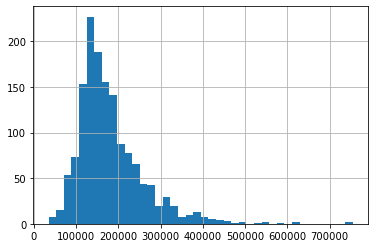

In [10]:
data['SalePrice'].hist(bins = 40)

<AxesSubplot:>

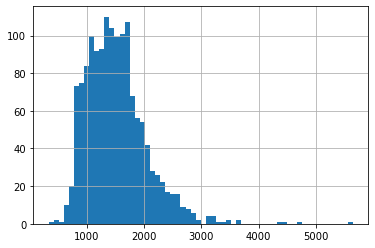

In [11]:
data['GrLivArea'].hist(bins = 60)

scipy.stats.johnsonsu 是 Johnson SU distribution 的機率密度函數 (probability density function, PDF)。Johnson SU distribution 是一種連續機率分布，可以用來建模具有左偏或右偏的非對稱資料。這種分布由 Johnson 在 1949 年提出，它將任意分布的值，透過一個標準正態分布的轉換，使得轉換後的值符合 Johnson SU distribution。

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

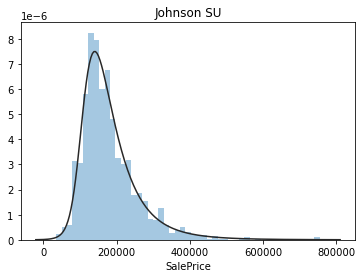

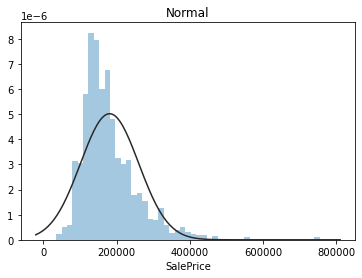

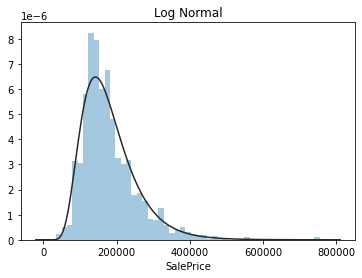

In [12]:
y = data['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

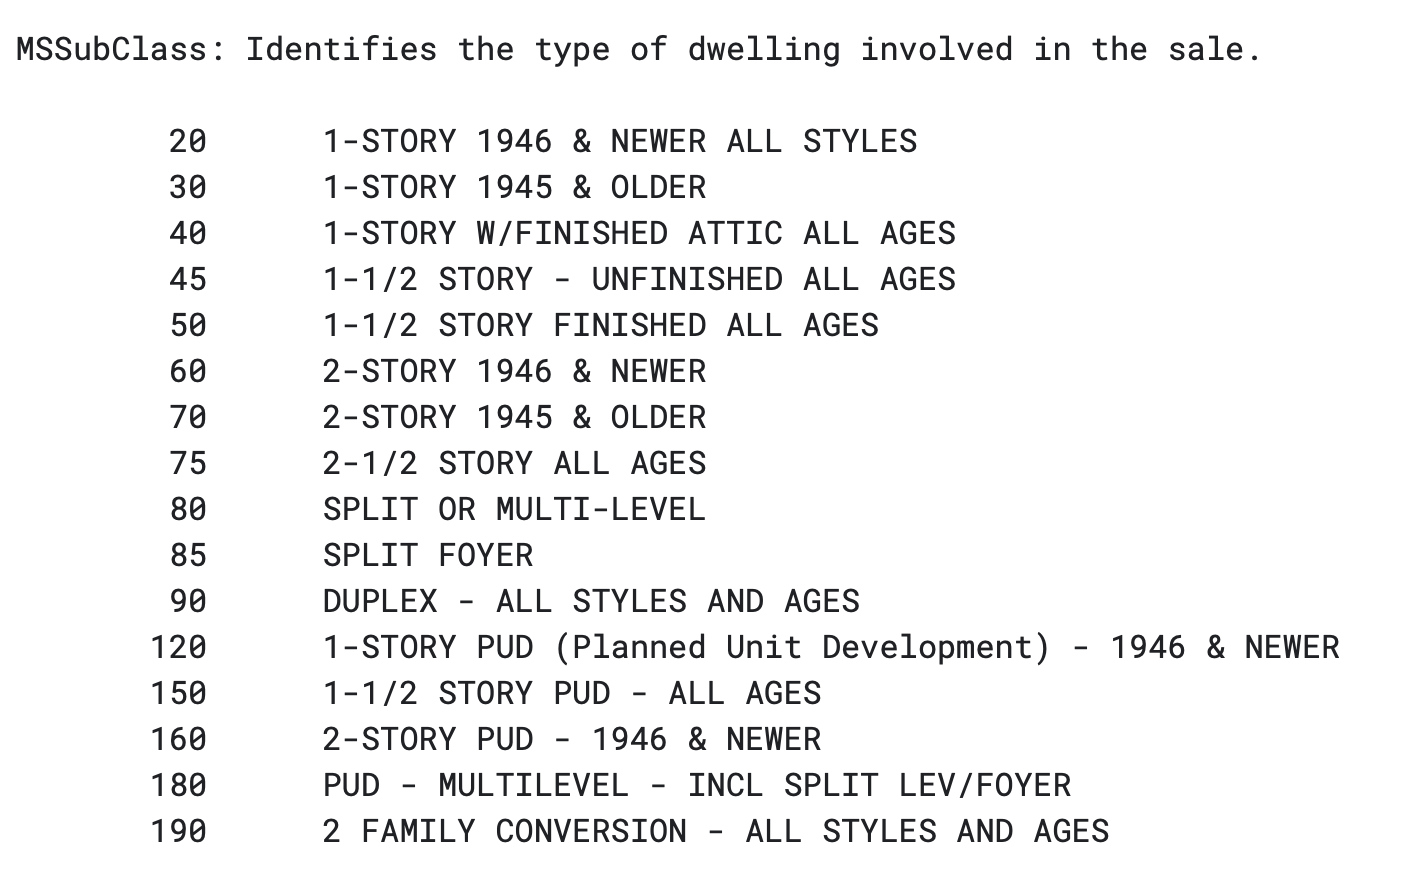
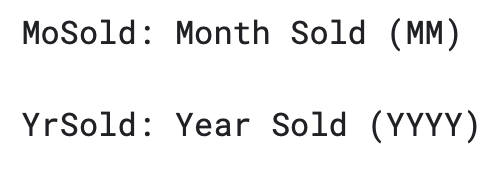

In [13]:
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
concat['MSSubClass'] = concat['MSSubClass'].apply(str)
concat['YrSold'] = concat['YrSold'].astype(str)
concat['MoSold'] = concat['MoSold'].astype(str)

In [14]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

In [15]:
data_c = data

這段程式碼是對質性特徵進行編碼的過程。首先定義了一個encode()函數，該函數會將質性特徵轉換為有序特徵（即用1至n的數字來表示特徵的大小關係），轉換過程根據SalePrice的平均值排序得到的順序。之後，使用for循環遍歷所有質性特徵，調用encode()函數將質性特徵轉換為有序特徵，並將編碼後的特徵名添加到列表qual_encoded中。

In [16]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(data_c, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSSubClass_E', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'MoSold_E', 'YrSold_E', 'SaleType_E', 'SaleCondition_E']


In [17]:
data_c.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,YrSold_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,15.0,4.0,2.0,NaN,1.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,1.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,NaN,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,4.0,1.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.0,4.0,2.0,NaN,1.0,2.0,2.0,2.0,1.0,21.0,3.0,5.0,5.0,6.0,2.0,3.0,5.0,6.0,2.0,2.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,6.0,5.0,2.0,5.0,2.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,2.0,5.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,15.0,4.0,2.0,NaN,2.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,2.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,12.0,1.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,10.0,4.0,2.0,NaN,2.0,2.0,2.0,3.0,1.0,18.0,5.0,5.0,5.0,7.0,2.0,3.0,6.0,9.0,2.0,2.0,4.0,2.0,2.0,4.0,1.0,4.0,5.0,6.0,4.0,2.0,5.0,3.0,7.0,4.0,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,4.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,15.0,4.0,2.0,NaN,2.0,2.0,2.0,2.0,1.0,25.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,3.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,10.0,1.0,5.0,5.0


<AxesSubplot:>

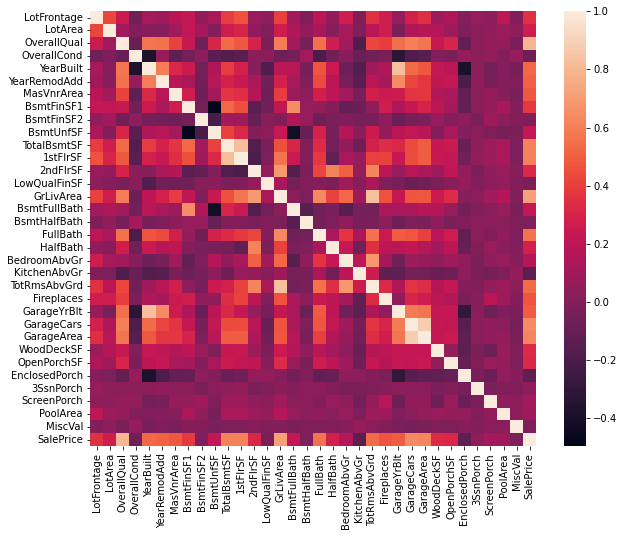

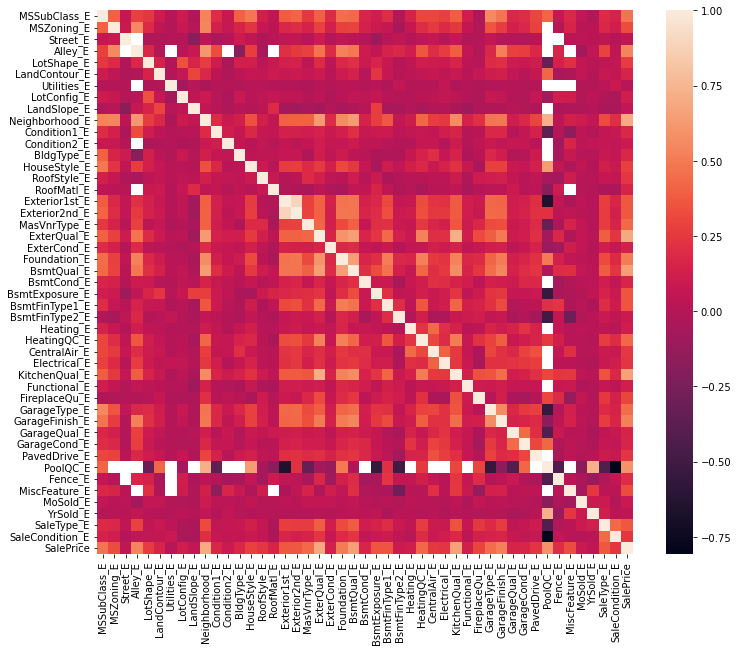

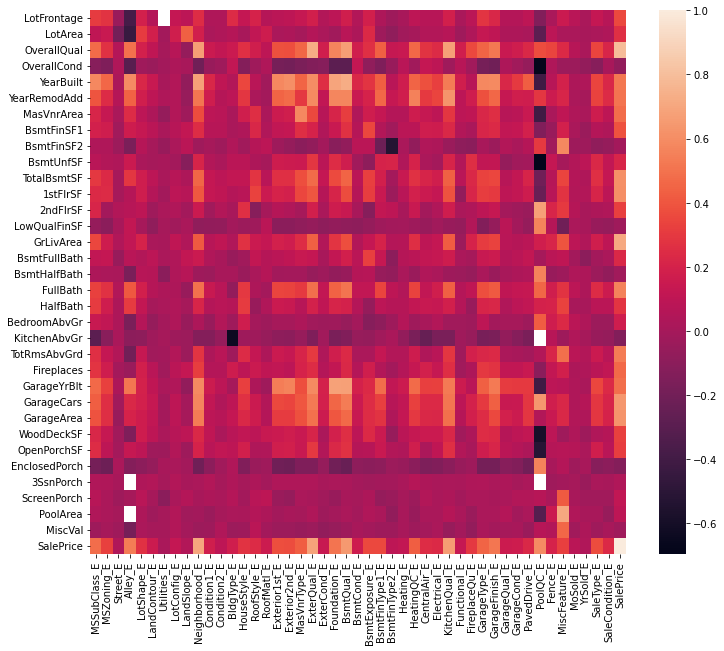

In [18]:

plt.figure(1, figsize=(10, 8))
corr = data_c[quantitative+['SalePrice']].corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)
plt.figure(2, figsize=(12, 10))
corr = data_c[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3, figsize=(12, 10))
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = data_c[q1].corr(data_c[q2])
sns.heatmap(corr)


there are too many missing value for PoolQC "1453/1460", better to drop this

In [19]:
missing_data = pd.concat([concat.isnull().sum(), concat.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(40)

,Missing Values,Data Type
PoolQC,2909,object
MiscFeature,2814,object
Alley,2721,object
Fence,2348,object
SalePrice,1459,float64
FireplaceQu,1420,object
LotFrontage,486,float64
GarageCond,159,object
GarageFinish,159,object
GarageQual,159,object


In [20]:
category_missing_1_to_5 = []
for i in categorical_columns:
    if concat[i].isna().sum() > 0 and concat[i].isna().sum() < 5:
        category_missing_1_to_5.append(i)
print(category_missing_1_to_5)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']


In [21]:
# show "categorical feature with missing value" value calculation
for i in category_missing_1_to_5:
    print(i)
    print("Number of missing values:", concat[i].isna().sum())
    print("Percentage of missing values:", round(concat[i].isna().sum() / len(data) * 100, 2), "%")
    print(concat[i].value_counts(dropna=False), '\n')

MSZoning
Number of missing values: 4
Percentage of missing values: 0.27 %
RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64 

Utilities
Number of missing values: 2
Percentage of missing values: 0.14 %
AllPub    2916
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64 

Exterior1st
Number of missing values: 1
Percentage of missing values: 0.07 %
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64 

Exterior2nd
Number of missing values: 1
Percentage of missing values: 0.07 %
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone      

In [22]:
concat['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64

## filling the missing data

### filling the missing data

In [23]:
concat_1 = concat

# drop datas that missing value is more than 75%
concat_1 = concat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)
# if #missing value < 5, simply fill in most frequent category
for col in ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']:
    concat_1[col] = concat_1[col].fillna(concat[col].mode()[0])
# missing value between 5-200, fill in nll or 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):#車庫年份、面積、容量
    concat_1[col] = concat_1[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    concat_1[col] = concat_1[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):#地下室 高度、
    concat_1[col] = concat_1[col].fillna('None')
for col in ('BsmtFullBath', 'BsmtHalfBath'):#地下室廁所數量，大多是0且缺失值都只有兩個，因此填入0
    concat_1[col] = concat_1[col].fillna(0)


In [24]:
# LotFrontage
#LotFrontage: Linear feet of street connected to property/ Neighborhood: Physical locations within Ames city limits
concat_1.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.dropna().sort_values().reset_index(drop=True))
concat_1['LotFrontage'] = concat_1.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [25]:
# FireplaceQu
concat_1['Fireplaces'].value_counts() #可以觀察到所有FireplaceQu的缺失值都是家中沒有fireplace的位置
for i, row in concat_1.iterrows():
    if row['Fireplaces'] == 0 and pd.isna(row['FireplaceQu']):
        concat_1.loc[i, 'FireplaceQu'] = 'None'

In [26]:
#plt.hist(concat_1['TotalBsmtSF'], bins=70)
#plt.show()
#concat_1['TotalBsmtSF'].value_counts()
for col in ['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea']:
    concat_1[col] = concat_1[col].fillna(concat[col].mode()[0])
concat_1['MasVnrType'] = concat_1['MasVnrType'].fillna(concat[col].mode()[0])

In [27]:
missing_data = pd.concat([concat_1.isnull().sum(), concat_1.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(30)

,Missing Values,Data Type
SalePrice,1459,float64
HalfBath,0,int64
FireplaceQu,0,object
Fireplaces,0,int64
Functional,0,object
TotRmsAbvGrd,0,int64
KitchenQual,0,object
KitchenAbvGr,0,int64
BedroomAbvGr,0,int64
FullBath,0,int64


In [28]:
missing_values = concat_1.isnull().sum()
print(missing_values)

MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBa

In [29]:
qualitative = [f for f in concat_1.columns if concat_1.dtypes[f] == 'object']
qualitative

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [30]:
quantitative = [f for f in concat_1.columns if concat_1.dtypes[f] != 'object']
quantitative

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

### one hot encoding

In [31]:
#將categorical features的值做 one-hot encoding
def category_onehot_multcols(multcolumns):
    df_final=concat_1
    i=0  
    for fields in multcolumns:
        print(fields)
        #將 final_df 中的欄位 fields 的值做 one-hot encoding，並且移除掉每個欄位的第一個值，以避免多重共線性的問題。
        df1=pd.get_dummies(concat_1[fields],drop_first=True) 
        concat_1.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
    df_final=pd.concat([concat_1,df_final],axis=1) 
    return df_final

In [32]:
concat_1=category_onehot_multcols(qualitative)

MSSubClass
MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
MoSold
YrSold
SaleType
SaleCondition


In [33]:
concat_1 =concat_1.loc[:,~concat_1.columns.duplicated()]

### delete catagoral feature

In [ ]:
concat_1.drop(qualitative, axis=1, inplace=True)

In [ ]:
concat_1.head(10)

### split the dataframe

In [34]:
data_1=concat_1.iloc[:1460,:]
test_1=concat_1.iloc[1460:,:]

In [44]:
test[10:15]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
10,1471,120,RH,26.0,5858,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,TwnhsE,1Story,7,5,1999,1999,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1051.0,BLQ,0.0,354.0,1405.0,GasA,Ex,Y,SBrkr,1337,0,0,1337,1.0,0.0,2,0,2,1,Gd,5,Typ,1,Fa,Attchd,1999.0,Fin,2.0,511.0,TA,TA,Y,203,68,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
11,1472,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,BrkFace,504.0,TA,TA,CBlock,TA,TA,No,Rec,156.0,Unf,0.0,327.0,483.0,GasA,TA,Y,SBrkr,483,504,0,987,0.0,0.0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1971.0,Unf,1.0,264.0,TA,TA,Y,275,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,COD,Normal
12,1473,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,5,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,BrkFace,492.0,TA,TA,CBlock,TA,TA,No,Rec,300.0,Unf,0.0,225.0,525.0,GasA,TA,Y,SBrkr,525,567,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1997.0,Unf,1.0,320.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
13,1474,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NPkVill,Norm,Norm,Twnhs,2Story,6,6,1975,1975,Gable,CompShg,Plywood,Brk Cmn,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,514.0,Unf,0.0,341.0,855.0,GasA,TA,Y,SBrkr,855,601,0,1456,0.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,1975.0,Unf,2.0,440.0,TA,TA,Y,173,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
14,1475,120,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NPkVill,Norm,Norm,Twnhs,1Story,7,6,1975,1975,Gable,CompShg,Plywood,Brk Cmn,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,836.0,836.0,GasA,Ex,Y,SBrkr,836,0,0,836,0.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,Attchd,1975.0,Unf,1.0,308.0,TA,TA,Y,0,30,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal


In [42]:
#test_1 = test_1.drop(['SalePrice'], axis=1)
test_1[10:15]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,150,160,180,190,20,30,40,45,50,60,70,75,80,85,90,FV,RH,RL,RM,Pave,IR2,IR3,Reg,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside,Mod,Sev,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,2fmCon,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,Brk Cmn,CmentBd,Other,Wd Shng,BrkCmn,None,Fa,Gd,TA,Po,PConc,Slab,Wood,Mn,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,10,11,12,2,3,4,5,6,7,8,9,2007,2008,2009,2010,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
1470,26.0,5858,7,5,1999,1999,0.0,1051.0,0.0,354.0,1405.0,1337,0,0,1337,1.0,0.0,2,0,2,1,5,1,1999.0,2.0,511.0,203,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1471,21.0,1680,6,5,1971,1971,504.0,156.0,0.0,327.0,483.0,483,504,0,987,0.0,0.0,1,1,2,1,5,0,1971.0,1.0,264.0,275,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1472,21.0,1680,5,5,1971,1971,492.0,300.0,0.0,225.0,525.0,525,567,0,1092,0.0,0.0,1,1,3,1,6,0,1997.0,1.0,320.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1473,24.0,2280,6,6,1975,1975,0.0,514.0,0.0,341.0,855.0,855,601,0,1456,0.0,0.0,2,1,3,1,6,1,1975.0,2.0,440.0,173,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1474,24.0,2280,7,6,1975,1975,0.0,0.0,0.0,836.0,836.0,836,0,0,836,0.0,0.0,1,0,2,1,4,0,1975.0,1.0,308.0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [36]:
data_1.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,150,160,180,190,20,30,40,45,50,60,70,75,80,85,90,FV,RH,RL,RM,Pave,IR2,IR3,Reg,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside,Mod,Sev,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,2fmCon,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,Brk Cmn,CmentBd,Other,Wd Shng,BrkCmn,None,Fa,Gd,TA,Po,PConc,Slab,Wood,Mn,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,10,11,12,2,3,4,5,6,7,8,9,2007,2008,2009,2010,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,208500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,181500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,223500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,140000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,250000.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [38]:
data_1_x=data_1.drop(['SalePrice'],axis=1)
data_1_y=data_1['SalePrice']

In [39]:
test_1.shape, data_1_x.shape, data_1_y.shape

((1459, 204), (1460, 204), (1460,))

## data transformation

### log level transformation

In [125]:
quantitative.remove('SalePrice')

In [ ]:
"""
# Skewing all features (Log level transform)
skewed_feats = data_1_x[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)
# skewed_feats = data_b.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print("\nSkew in numerical features: \n", skewness)

skewness = skewness[abs(skewness['Skew']) > 1]
#skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to Log1p transform".format(skewness.shape[0]))
print(skewness)

skewed_features = skewness.index
for feat in skewed_features:
    data_1_x[feat] = np.log1p(data_1_x[feat])
    test_1[feat] = np.log1p(test_1[feat])
"""

In [126]:
data_1_x_log = np.log1p(data_1_x)
test_1_log = np.log1p(test_1)

In [127]:
# Convert Target also Log level
data_1_y_log = np.log1p(data_1_y)

In [ ]:
data_1_x_log.head(15)

### standarlize

In [ ]:
# 取得所有數值特徵的column名稱
numeric_columns = data_1_x.select_dtypes(include=np.number).columns.tolist()
print(len(numeric_columns))

In [ ]:
# 進行標準化
scaler = StandardScaler()
data_1_x_stand = scaler.fit_transform(data_1_x)
test_1_stand = scaler.fit_transform(test_1)

In [ ]:
test_1_stand = scaler.inverse_transform(test_1_stand)
test_1_stand = pd.DataFrame(test_1_stand, columns = numeric_columns)
data_1_x_stand = scaler.inverse_transform(data_1_x_stand)
data_1_x_stand = pd.DataFrame(data_1_x_stand, columns = numeric_columns)


In [ ]:
data_1_x_stand.head()

In [ ]:
test_1_stand.head()

In [ ]:
data_1_y_array = data_1_y.values.reshape(-1, 1)
data_1_y_stand = scaler.fit_transform(data_1_y_array)
data_1_y_stand = pd.DataFrame(data_1_y_stand, columns = ['SalePrice'])
data_1_y_stand.head()


## Feature selection-choose one section to run(optional)

### Lasso

In [156]:
alpha = [0.001, 0.01, 0.1, 0.5, 0.7]
for i in range(5):
    baseline = Lasso(alpha = alpha[i], random_state=0)
    baseline_score = cross_val_score(baseline, data_1_x_log, data_1_y_log, cv=10)
    print("when alpha = ", alpha[i] , " ", "Lasso avg:",np.mean(baseline_score))

when alpha =  0.001   Lasso avg: 0.8893243802157098
when alpha =  0.01   Lasso avg: 0.8149146541069765
when alpha =  0.1   Lasso avg: 0.4310232686234713
when alpha =  0.5   Lasso avg: -0.007368831810191679
when alpha =  0.7   Lasso avg: -0.007368831810191679


In [217]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# 创建 Lasso 模型对象
lasso = Lasso(alpha=0.00003)  # 设置 alpha 参数

# 训练 Lasso 模型
lasso.fit(data_1_x_log, data_1_y_log)

# 创建 SelectFromModel 对象，使用 Lasso 模型进行特征选择
selector = SelectFromModel(lasso, threshold='0.0001*median')  # 设置阈值，选择重要性大于阈值的特征

# 对特征进行选择
data_1_x_new = selector.transform(data_1_x_log)  # 选择后的特征矩阵

In [218]:
data_1_x_new = pd.DataFrame(data_1_x_new, columns=data_1_x.columns[selector.get_support()])
data_1_x_new.shape

(1460, 176)

In [219]:
set(data_1_x.columns) - set(data_1_x_new.columns)

{'150',
 '2.5Fin',
 '2fmCon',
 '40',
 '60',
 '75',
 'AsphShn',
 'Blueste',
 'Brk Cmn',
 'ConLw',
 'Duplex',
 'Family',
 'FuseP',
 'GasA',
 'ImStucc',
 'Mansard',
 'Mix',
 'Partial',
 'Plywood',
 'Po',
 'RRNe',
 'SLvl',
 'Shed',
 'Stone',
 'Stucco',
 'Timber',
 'TwnhsE',
 'WD'}

In [116]:
test_1_new = test_1[data_1_x_new.columns]

#### Lesso to get result

In [ ]:
lasso = Lasso(alpha = 0.00003,random_state=0).fit(data_1_x, data_1_y)
lasso_preds=lasso.predict(test_1)

In [ ]:
##Create Sample Submission file and Submit using ANN
pred=pd.DataFrame(lasso_preds)
#sub_df=pd.read_csv('formulatedtest.csv')
datasets=pd.concat([test['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('test3.csv',index=False)

In [ ]:
datasets.head()

### correlation

In [ ]:
corr_matrix = data_1_x.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
data_1_x_new = data_1_x.drop(to_drop, axis=1)
data_1_x_new.shape

In [ ]:
set(data_1_x.columns) - set(data_1_x_new.columns)

In [ ]:
test_1_new = test_1[data_1_x_new.columns]

### mutual_info_regression

In [ ]:
scores = mutual_info_regression(data_1_x, data_1_y)
# 建立一個dataframe儲存特徵和它們的mutual information
mi_df = pd.DataFrame({'feature': data_1_x.columns, 'MI': scores})

# 根據mutual information排序
mi_df = mi_df.sort_values('MI', ascending=False)
mi_df


In [ ]:
selected_features = data_1_x.columns[scores > 0.0001]
data_1_x_new = data_1_x[selected_features]
data_1_x_new.shape, data_1_x_new.columns

In [ ]:
set(data_1_x.columns) - set(data_1_x_new.columns)

In [ ]:
featuresToKeep = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'RL', 'RM',
        'Reg', 'NAmes', 'NridgHt', 'Somerst', 'VinylSd', 'None', 'Gd', 'TA',
        'PConc', 'GLQ', 'Y', 'SBrkr', 'Attchd', 'Detchd', 'RFn', 'New',
        'Partial']
test_1_mutual = test_1[featuresToKeep]
test_1_mutual.shape

In [ ]:
test_1.shape

### random forest

In [ ]:
clf = RandomForestRegressor()
clf.fit(data_1_x, data_1_y)

model = SelectFromModel(clf, prefit=True)
data_1_x_new = model.transform(data_1_x)

In [ ]:
data_1_x_new = pd.DataFrame(data_1_x_new, columns=data_1_x.columns[model.get_support()])
data_1_x_new.shape, data_1_x_new.columns

### PCA(主成分分析)

In [ ]:
# 標準化自變數
scaler = StandardScaler()
X_std = scaler.fit_transform(data_1_x)

# 創建PCA實例
pca = PCA(n_components=None)

# 擬合PCA模型
pca.fit(X_std)

# 確定保留的主成分個數
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print("Number of components required to explain 80% of the data:", n_components)

In [ ]:
# 確定保留80%(84個)主成分
pca = PCA(n_components=n_components)
pca.fit(X_std)
X_pca = pca.transform(X_std)

# 將PCA轉換為DataFrame
col_names = [f'PC{i}' for i in range(1, n_components+1)]
df_data_pca = pd.DataFrame(data=X_pca, columns=col_names)
#df_pca = pd.concat([df_pca, data_1_y], axis=1)
df_data_pca.head()

In [ ]:
# 確定主成分的載荷量
loadings = pd.DataFrame(pca.components_.T, columns=col_names, index=data_1_x.columns)
print(loadings.abs())

# 確定各自變數的貢獻度
contributions = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance Ratio'], index=col_names)
print(contributions)

In [ ]:
test_std = scaler.fit_transform(test_1)
test_pca = pca.transform(test_std)
df_test_pca = pd.DataFrame(data=test_pca, columns=col_names)

df_test_pca.head()

## prediction

In [118]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
regressor = xgboost.XGBRegressor()

In [ ]:
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.15, 0.20]
min_child_weight = [1, 2, 3, 4]
#booster = ['gbtree', 'gblinear']

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    #'booster':booster,
    #'base_score':base_score
    }

In [ ]:
random_cv = RandomizedSearchCV(
            estimator = regressor,
            param_distributions = hyperparameter_grid,
            n_iter=50,
            n_jobs = -1,        
            scoring = 'neg_mean_absolute_error',
            cv=5, 
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv.fit(data_1_x, data_1_y)

In [ ]:
random_cv.best_estimator_

In [ ]:
regressor=xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=np.nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [119]:
regressor.fit(data_1_x_new, data_1_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(regressor, open(filename, 'wb'))

In [120]:
y_pred = regressor.predict(test_1_new)

In [121]:
##Create Sample Submission file and Submit using ANN
pred=pd.DataFrame(y_pred)
#sub_df=pd.read_csv('formulatedtest.csv')
datasets=pd.concat([test['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']

In [ ]:
# if use log level tranformation, change back
datasets['SalePrice'] = np.exp(y_pred)-1

### stan inverse transform

In [ ]:
##Create Sample Submission file and Submit using ANN
pred=pd.DataFrame(y_pred)

# 假設 data_1_y_stand 是已經標準化過的數值的 DataFrame
# 要將其轉回原來的尺度，可以使用 inverse_transform() 方法
pred = scaler.inverse_transform(pred)
# 將轉換後的數值重新轉換為 DataFrame
pred = pd.DataFrame(pred, columns=['SalePrice'])

In [ ]:
datasets=pd.concat([test['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
# 輸出結果
datasets.head()

### output to .csv

In [124]:
datasets.to_csv('lasso_noLog_noStand_oneHot.csv',index=False)

In [122]:
datasets.head()

,Id,SalePrice
0,1461,126476.820312
1,1462,139407.687500
2,1463,160690.421875
3,1464,177289.328125
4,1465,138365.156250
